#################import the needed library###############

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

################# Parameters #####################

In [11]:
path = "myData"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 50  
epochs_val = 80
imageDimesions = (32, 32, 3)
testRatio = 0.2 
validationRatio = 0.2

############################### Importing of the Images ##########################
here we are reading the dataset folder and gives evey image the right classe

In [50]:
count = 0
images= []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)


Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


############################### Split Data ##################################

In [60]:
images.shape

(34799, 32, 32, 3)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET #############################

In [52]:
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)


Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


############################### READ CSV FILE ######################

In [53]:
data=pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


############################### PREPROCESSING THE IMAGES ######################

In [54]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [55]:
X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [56]:
print(X_train.shape)

(22271, 32, 32)


In [57]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [58]:
print(X_train.shape)

(22271, 32, 32, 1)


###################################### AUGMENTATAION OF IMAGES TO MAKE IT MORE GENERIC ##############

In [16]:
dataGen = ImageDataGenerator(width_shift_range=0.1,    # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

############################### CONVOLUTION NEURAL NETWORK MODEL#####################

In [17]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5) 
                            
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2) 
    no_Of_Nodes = 500 
    model = Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))
    
    model.add((Conv2D(no_Of_Filters,size_of_Filter,activation='relu')))
    
#   model.add(AveragePooling2D(pool_size=size_of_pool))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    
    model.add((Conv2D(no_Of_Filters//2,size_of_Filter2,activation='relu')))
    
#   model.add(AveragePooling2D(pool_size=size_of_pool))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    
    model.add(Dropout(0.5))
    #model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(no_Of_Nodes,activation='relu'))
    
    model.add(Dropout(0.5))
    #model.add(Dropout(0.2))
    
    model.add(Dense(noOfClasses,activation='softmax'))

    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

############################### TRAIN ########################

In [15]:
model = myModel()
print(model.summary())
history = model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=(len(X_train)/batch_size_val),epochs=epochs_val,validation_data=(X_validation, y_validation), shuffle=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

Epoch 45/80
446/445 [==============================] - 80s 179ms/step - loss: 0.1193 - accuracy: 0.9633 - val_loss: 0.0221 - val_accuracy: 0.9937
Epoch 46/80
446/445 [==============================] - 79s 176ms/step - loss: 0.1234 - accuracy: 0.9625 - val_loss: 0.0150 - val_accuracy: 0.9960
Epoch 47/80
446/445 [==============================] - 78s 175ms/step - loss: 0.1254 - accuracy: 0.9620 - val_loss: 0.0140 - val_accuracy: 0.9966
Epoch 48/80
446/445 [==============================] - 78s 174ms/step - loss: 0.1181 - accuracy: 0.9642 - val_loss: 0.0134 - val_accuracy: 0.9973
Epoch 49/80
446/445 [==============================] - 77s 173ms/step - loss: 0.1220 - accuracy: 0.9626 - val_loss: 0.0225 - val_accuracy: 0.9943
Epoch 50/80
446/445 [==============================] - 77s 173ms/step - loss: 0.1205 - accuracy: 0.9644 - val_loss: 0.0149 - val_accuracy: 0.9960
Epoch 51/80
446/445 [==============================] - 77s 173ms/step - loss: 0.1170 - accuracy: 0.9648 - val_loss: 0.0257 -

############################### PLOT ##########################

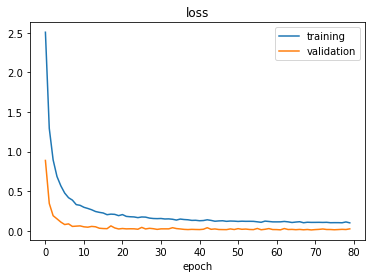

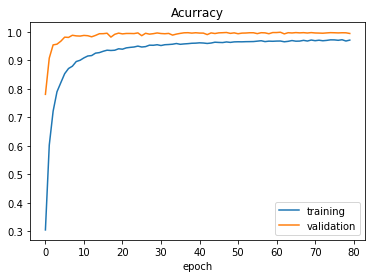

Test Score: 0.025023043155670166
Test Accuracy: 0.9918103218078613


In [16]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

########################To Save The Model And Use It Later ############################

In [17]:
model.save('model.h5')